В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/edce80b5bb02479085855b2334b17fc1). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

In [6]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-3/data?select=test.csv'

In [8]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yanakalashnikova
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 681MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu-course-c-3/bank-customer-churn-prediction-dlu-course-c-3.zip to ./bank-customer-churn-prediction-dlu-course-c-3


In [13]:
import pandas as pd

In [14]:
train_df = pd.read_csv('/content/bank-customer-churn-prediction-dlu-course-c-3/train.csv')

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [17]:
# Визначаємо назви колонок
input_cols = [
    'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
    'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'
]
target_col = 'Exited'

# Вибираємо незалежні змінні (X) та цільову змінну (y)
X = train_df[input_cols]
y = train_df[target_col]

# Розділяємо на train/val з балансуванням класів
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Перевірка
print("Train shape:", train_inputs.shape)
print("Validation shape:", val_inputs.shape)
print("Train targets distribution:\n", train_targets.value_counts(normalize=True))
print("Val targets distribution:\n", val_targets.value_counts(normalize=True))


Train shape: (12000, 10)
Validation shape: (3000, 10)
Train targets distribution:
 Exited
0.0    0.7965
1.0    0.2035
Name: proportion, dtype: float64
Val targets distribution:
 Exited
0.0    0.796667
1.0    0.203333
Name: proportion, dtype: float64


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [18]:
# Назви колонок
input_cols = [
    'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
    'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'
]
target_col = 'Exited'

# Піднабори вже створені:
# train_inputs, val_inputs — датафрейми з ознаками
# train_targets, val_targets — серії з цільовою змінною

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [19]:
numeric_cols = train_inputs.select_dtypes(include='number').columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

print("🔢 Numeric columns:", numeric_cols)
print("🔠 Categorical columns:", categorical_cols)

🔢 Numeric columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
🔠 Categorical columns: ['Geography', 'Gender']


4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [21]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Створимо копії, щоб не зіпсувати оригінальні
train_proc = train_inputs.copy()
val_proc = val_inputs.copy()

# Масштабування числових ознак
# Знайдемо числові колонки
numeric_cols = train_proc.select_dtypes(include='number').columns.tolist()

# Ініціалізуємо скейлер
scaler = StandardScaler()

# Навчаємо скейлер на train і застосовуємо до обох
train_proc[numeric_cols] = scaler.fit_transform(train_proc[numeric_cols])
val_proc[numeric_cols] = scaler.transform(val_proc[numeric_cols])

#  Кодування категоріальних колонок
# Знайдемо категоріальні (текстові) колонки
categorical_cols = train_proc.select_dtypes(include='object').columns.tolist()

# One-hot encoding з drop_first — щоб уникнути надмірності
train_proc = pd.get_dummies(train_proc, columns=categorical_cols, drop_first=True)
val_proc = pd.get_dummies(val_proc, columns=categorical_cols, drop_first=True)

# Узгодження колонок після кодування
# Інколи у train і val — різні dummy-колонки
# .align гарантує, що обидва мають однакові колонки
train_proc, val_proc = train_proc.align(val_proc, join='left', axis=1, fill_value=0)

# Вивід перших 5 рядків
from IPython.display import display

print("🟦 Передоброблені train_inputs:")
display(train_proc.head())

print("🟩 Передоброблені val_inputs:")
display(val_proc.head())

🟦 Передоброблені train_inputs:


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7180,0.320187,-0.944682,-1.447264,1.475464,-1.108193,0.515062,1.016977,0.569450,False,False,True
10393,0.347838,0.161227,-1.087792,2.254434,-1.108193,0.515062,-0.983306,0.603803,False,False,False
80,0.638166,-0.330288,0.350096,1.223831,0.769304,0.515062,-0.983306,1.238026,True,False,True
3365,0.140460,2.495924,-1.806736,-0.717950,0.769304,-1.941514,1.016977,-1.457116,False,True,True
12236,0.665816,-2.050591,-0.728320,-0.717950,0.769304,0.515062,1.016977,0.670629,False,False,True


🟩 Передоброблені val_inputs:


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
6490,0.762592,1.021379,-1.447264,1.214543,4.524299,0.515062,1.016977,-0.988144,True,False,True
3646,-0.910252,0.406985,-0.009376,-0.717950,0.769304,0.515062,1.016977,-1.750392,False,False,True
5306,0.997620,0.038348,-1.087792,-0.717950,0.769304,-1.941514,1.016977,-0.022404,False,False,False
652,0.195761,0.652742,-0.368848,1.881867,-1.108193,-1.941514,1.016977,-0.139723,False,False,False
2627,0.264887,-0.944682,-0.368848,-0.717950,0.769304,0.515062,-0.983306,0.563519,False,True,False


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [22]:
import os

# Створимо папку для збереження (якщо ще не існує)
save_dir = 'prepared_data'
os.makedirs(save_dir, exist_ok=True)

# Зберігаємо у parquet
train_proc.to_parquet(f'{save_dir}/train_inputs.parquet')
train_targets.to_frame().to_parquet(f'{save_dir}/train_targets.parquet')

val_proc.to_parquet(f'{save_dir}/val_inputs.parquet')
val_targets.to_frame().to_parquet(f'{save_dir}/val_targets.parquet')

# Перевіримо, що збереглось
print("📂 Збережені файли:")
print(os.listdir(save_dir))

📂 Збережені файли:
['train_inputs.parquet', 'val_targets.parquet', 'val_inputs.parquet', 'train_targets.parquet']


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [23]:
from sklearn.linear_model import LogisticRegression

# Підготовка X і y
X_train = train_proc
X_val = val_proc
y_train = train_targets
y_val = val_targets

# Ініціалізуємо модель логістичної регресії
model = LogisticRegression(max_iter=1000, random_state=42)

# Навчаємо модель
model.fit(X_train, y_train)

# Перевіримо, що модель навченa
print("✅ Модель успішно натренована!")

✅ Модель успішно натренована!


7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

📊 Confusion Matrix (train):


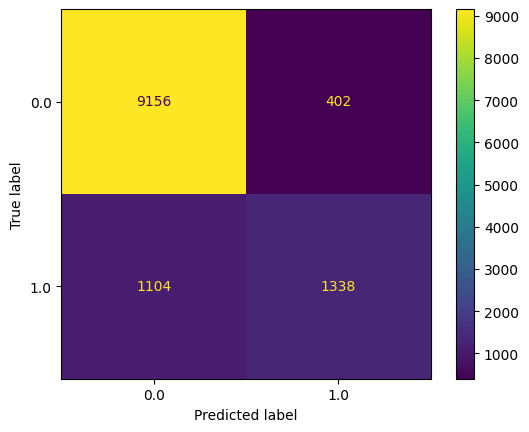

📊 Confusion Matrix (val):


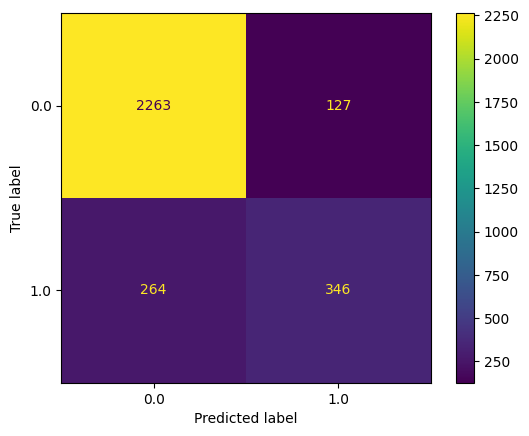

📈 ROC Curve:


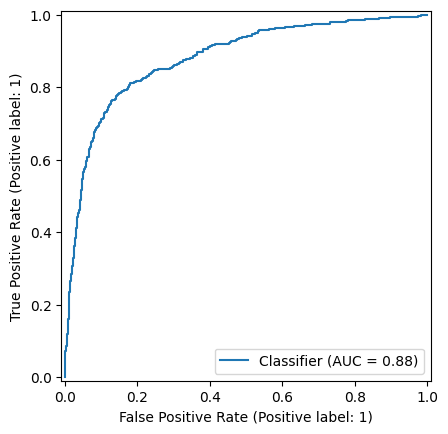

🔵 AUC-ROC (train): 0.8825
🟢 AUC-ROC (val): 0.8797
🔵 F1 Score (train): 0.6399
🟢 F1 Score (val): 0.6390


In [24]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, RocCurveDisplay,
    roc_auc_score, f1_score
)
import matplotlib.pyplot as plt

# Отримуємо ймовірності для класу 1
y_train_probs = model.predict_proba(X_train)[:, 1]
y_val_probs = model.predict_proba(X_val)[:, 1]

# Отримуємо класи при порозі 0.5
y_train_pred = (y_train_probs >= 0.5).astype(int)
y_val_pred = (y_val_probs >= 0.5).astype(int)

# Confusion Matrix
print("📊 Confusion Matrix (train):")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

print("📊 Confusion Matrix (val):")
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
plt.show()

# ROC-крива
print("📈 ROC Curve:")
RocCurveDisplay.from_predictions(y_val, y_val_probs)
plt.show()

# Метрики
train_auc = roc_auc_score(y_train, y_train_probs)
val_auc = roc_auc_score(y_val, y_val_probs)

train_f1 = f1_score(y_train, y_train_pred)
val_f1 = f1_score(y_val, y_val_pred)

print(f"🔵 AUC-ROC (train): {train_auc:.4f}")
print(f"🟢 AUC-ROC (val): {val_auc:.4f}")
print(f"🔵 F1 Score (train): {train_f1:.4f}")
print(f"🟢 F1 Score (val): {val_f1:.4f}")

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [25]:
from sklearn.metrics import accuracy_score

# Знайдемо мажоритарний клас у train
majority_class = train_targets.value_counts().idxmax()
print(f"📌 Мажоритарний клас: {majority_class}")

# Створюємо "дурну" модель — завжди передбачає цей клас
y_train_majority = [majority_class] * len(train_targets)
y_val_majority = [majority_class] * len(val_targets)

# Accuracy цієї моделі
train_acc_baseline = accuracy_score(train_targets, y_train_majority)
val_acc_baseline = accuracy_score(val_targets, y_val_majority)

# Accuracy логістичної регресії (для порівняння)
from sklearn.metrics import accuracy_score

logreg_train_acc = accuracy_score(train_targets, y_train_pred)
logreg_val_acc = accuracy_score(val_targets, y_val_pred)

# Виводимо
print(f"🪵 Baseline Accuracy (train): {train_acc_baseline:.4f}")
print(f"🪵 Baseline Accuracy (val):   {val_acc_baseline:.4f}")

print(f"🤖 LogisticRegression Accuracy (train): {logreg_train_acc:.4f}")
print(f"🤖 LogisticRegression Accuracy (val):   {logreg_val_acc:.4f}")


📌 Мажоритарний клас: 0.0
🪵 Baseline Accuracy (train): 0.7965
🪵 Baseline Accuracy (val):   0.7967
🤖 LogisticRegression Accuracy (train): 0.8745
🤖 LogisticRegression Accuracy (val):   0.8697


9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [26]:
import joblib

# Збереження моделі
joblib.dump(model, 'log_reg.joblib')

# Можна також зберегти скейлер (щоб потім масштабувати нові дані)
joblib.dump(scaler, 'scaler.joblib')


['scaler.joblib']

In [27]:
# Завантаження моделі з файлу
model_2 = joblib.load('log_reg.joblib')

# Перевіримо, чи працює завантажена модель
sample_probs = model_2.predict_proba(X_val[:5])[:, 1]
print("🧪 Передбачення ймовірностей (model_2):", sample_probs)


🧪 Передбачення ймовірностей (model_2): [0.01315983 0.04034551 0.05853197 0.20259268 0.05074632]


10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [36]:
def predict_raw_df(model, scaler, train_columns, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    # 1. Копія вхідного датафрейму
    df = input_df.copy()

    # 2. Масштабування числових колонок
    df[numeric_cols] = scaler.transform(df[numeric_cols])

    # 3. One-hot encoding для категоріальних колонок
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # 4. Вирівнюємо колонки як у train
    df = df.reindex(columns=train_columns, fill_value=0)

    # 5. Передбачення
    prob = model.predict_proba(df)[:, 1]
    return prob

In [37]:
raw_df = val_inputs.copy()

In [38]:
raw_df = val_inputs.copy()

predict_raw_df(
    model,
    scaler,
    train_proc.columns.tolist(),
    numeric_cols,
    categorical_cols,
    raw_df[:5]
)

array([0.01315983, 0.04034551, 0.05853197, 0.20259268, 0.05074632])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [39]:
# Зчитування test.csv
test_raw_df = pd.read_csv('/content/bank-customer-churn-prediction-dlu-course-c-3/test.csv')

# Виділяємо лише ті самі колонки, що й у train
test_raw_inputs = test_raw_df[input_cols].copy()


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [41]:
# тримання ймовірностей класу 1
test_probs = predict_raw_df(
    model,
    scaler,
    train_proc.columns.tolist(),
    numeric_cols,
    categorical_cols,
    test_raw_inputs
)

# Запис у колонку Exited
test_raw_df['Exited'] = test_probs

In [42]:
# Зчитуємо шаблон
sample_submission = pd.read_csv('/content/bank-customer-churn-prediction-dlu-course-c-3/sample_submission.csv')

# Записуємо передбачення
sample_submission['Exited'] = test_raw_df['Exited']

# Зберігаємо у CSV без індексів
sample_submission.to_csv('submission_log_reg.csv', index=False)

# Перевірка
sample_submission.head()

,id,Exited
0,15000,0.069269
1,15001,0.033349
2,15002,0.153780
3,15003,0.198624
4,15004,0.054094
